# Image segmentation with U-Net

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lento234/ml-tutorials/blob/main/02-advanced/advanced.ipynb)

<span style="color:red;"> On the main menu, click Runtime and select **Change runtime type**. "GPU" as the hardware accelerator.</span>

In [1]:
!nvidia-smi

Mon Jan 11 16:02:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   26C    P8     2W / 260W |     74MiB / 11010MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

----
## U-Net

A U-net architecture, as depicted below, is one of the most popular CNN architecture for image segmentation, initially used for [Biomedical image segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).


<div align="center">
    <img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="unet" width="800"/>
</div>

### Datasets:
- http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/
- Dataset: https://www.robots.ox.ac.uk/%7Evgg/data/pets/
- pix2pix
- https://github.com/NVIDIA/semantic-segmentation
- CamVidDataset: 
    - https://github.com/qubvel/segmentation_models.pytorch
    - http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid

## Table of  content

----

## Setup

Lightning is easy to install. Simply ```pip install pytorch-lightning```

In [2]:
!pip install pytorch-lightning --quiet

#### Download dataset

### Environment

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np
import glob

In [21]:
pl.seed_everything(234)

234

### Hyper-parameters

In [22]:
batch_size = 32
num_workers = 4
num_epochs = 5
learning_rate = 0.001
momentum = 0.9

<a id='load'></a>
## 1. Load and pre-process data

- Define preprocessing algorithm
- Load training and test dataset

### 1.1 Define preprocessing algorithm

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert data to pytorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize dataset for each channel
])

In [62]:
i = 40
image = plt.imread(glob.glob('./data/CamVidDataset/train/images/*')[i])
label = plt.imread(glob.glob('./data/CamVidDataset/train/labels/*')[i])

plt.imshow(label*100, cmap='gist_rainbow', vmin=3, vmax=3.5)
plt.colorbar()

In [73]:
classes = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

# classes.index('car')
[classes.index(cls.lower()) for cls in ['car']]

In [78]:
!pip install opencv-python -q

^C
ERROR: Operation cancelled by user


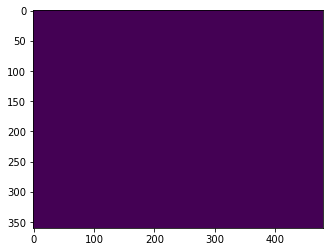

In [37]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
axes[0].imshow(image)
axes[1].imshow(label)

In [65]:
label

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01176471, 0.01176471, 0.01176471, ..., 0.01176471, 0.01176471,
        0.01176471],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.01176471, 0.01176471,
        0.01176471],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.01176471, 0.01176471,
        0.01176471]], dtype=float32)

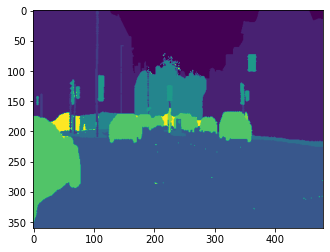

In [71]:
plt.imshow(plt.imread(glob.glob('./data/CamVidDataset/train/labels/*')[i], format='png'))

### 1.2 Load training and test dataset

In [8]:
# Download train and test dataset
train_dataset = datasets.Cityscapes(root='./data', split='train')
# test_dataset = datasets.Cityscapes(root='./data', train=False, 
#                                  download=True, transform=transform)

# # Dataset sampler (shuffle, distributed loading)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
#                                            shuffle=True, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
#                                           shuffle=False, num_workers=num_workers)

# print(f"num. examples: train = {len(train_dataset)}, test = {len(test_dataset)}")

# classes = np.array(['plane', 'car', 'bird', 'cat', 'deer',
#                     'dog', 'frog', 'horse', 'ship', 'truck'])

# num_classes = len(classes)

# # Functions to show an image
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.figure(figsize=(15,10))
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# images, labels = next(iter(train_loader))

# # show images
# imshow(torchvision.utils.make_grid(images, pad_value=1))
# print(classes[labels])

RuntimeError: Dataset not found or incomplete. Please make sure all required folders for the specified "split" and "mode" are inside the "root" directory

<a id=define></a>
## 2. Define the CNN model **+ training step + loss + optimizer**

### 2.1 Define the conv. blocks of UNET

In [278]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.block(x)

    
class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConvBlock(in_ch, out_ch)
        )
    
    def forward(self, x):
        return self.block(x)
    
    
class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2,
                                           kernel_size=2, stride=2)
        self.block = double_conv_block(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        # Pad
        diff_h = x2.shape[2] - x1.shape[2]
        diff_w = x2.shape[3] - x1.shape[3]
        x1 = F.pad(x1, [diff_w//2, diff_w - diff_w//2, diff_h//2, diff_h-diff_h//2])
        # Concatenate + conv
        x = torch.cat([x2, x1], dim=1)
        return self.block(x)
           

### 2.2 Define the U-Net

In [272]:
class UNet(pl.LightningModule):
    def __init__(self, num_classes, num_input_features=3, num_layers=5, base_features=32, **kwargs):
        super(UNet, self).__init__()
        
        # save hyper-parameters
        self.save_hyperparameters()
        
        # Encoder blocks
        features = self.hparams.base_features * (2 ** np.arange(self.hparams.num_layers))
        setattr(self, f'encoder_block{0}', DoubleConvBlock(self.hparams.num_input_features, features[0]))
        for i, (in_ch, out_ch) in enumerate(zip(features[:-1], features[1:])):
            setattr(self, f'encoder_block{i+1}', Encoder(in_ch, out_ch))
        
        # Decoder blocks
        for i, (in_ch, out_ch) in enumerate(zip(features[::-1], features[::-1][1:])):
            setattr(self, f'decoder_block{self.hparams.num_layers-1-i}', Decoder(in_ch, out_ch))
            
        # Output layer
        setattr(self, f'decoder_block{0}', nn.Conv2d(features[0], self.hparams.num_classes, kernel_size=1))
      
        self.example_input_array = torch.ones(1, self.hparams.num_input_features, 64, 64)
            
    def forward(self, x):
        xi = [x]
        # Encoding
        for i in range(self.hparams.num_layers):#self.blocks[1:self.hparams.num_layers]:
            xi.append(getattr(self, f'encoder_block{i}')(xi[-1]))
        # Decoding
        for i in reversed(range(1, self.hparams.num_layers)):
            xi[-1] = getattr(self, f'decoder_block{i}')(xi[-1], xi[i-self.hparams.num_layers-1])
        return self.decoder_block0(xi[-1])
    
    def training_step(self, batch, batch_nb):
        x_train, y_train = batch
        y_pred = self(x_train)
        if self.num_classes > 1:
            loss = F.cross_entropy(y_pred, y_train)
        else:
            loss = F.binary_cross_entropy_with_logits(y_pred, y_train)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True) # logging
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.1)
    
#     def validation_step(self, batch, batch_idx):
#         x_test, y_test = batch
#         y_pred = self(x_test)
#         loss = F.cross_entropy(y_pred, y_test) # loss
#         self.log('val_loss', loss)
        
#     def test_step(self, batch, batch_idx):
#         x_test, y_test = batch
#         y_pred = self(x_test)
#         loss = F.cross_entropy(y_pred, y_test)
#         self.log('test_loss', loss)
    
#     def configure_optimizers(self):
#         return torch.optim.SGD(self.parameters(),
#                                lr=self.hparams.learning_rate,
#                                momentum=self.hparams.momentum)
    

In [273]:
# Construct model
model = UNet(num_classes=1, num_input_features=3, num_layers=5, base_features=32)
model;

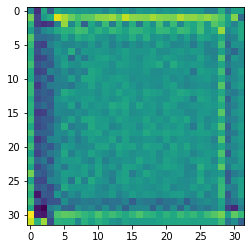

In [290]:
plt.imshow(model(torch.ones(1,3, 32, 32)).detach().numpy()[0,0])

<a id=trainer></a>
## 3. Setup the **trainer**

### 3.1 Define a logger

In [274]:
# logger = pl.loggers.TensorBoardLogger(save_dir="lightning_logs", 
#                                       name="CIFAR10",
#                                       log_graph=True)

# # Further loggers: https://pytorch-lightning.readthedocs.io/en/latest/logging.html
# # Commet.ml, CSV, MLflow, Neptune, Tensorboard, TestTube, WandB

### 3.2 Callbacks

In [275]:
# # Early stopping
# early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(monitor='val_loss')

# # checkpoint
# checkpoint_callback = pl.callbacks.ModelCheckpoint(
#     monitor='val_loss',
#     save_top_k=3,
# )


### 3.2 Initialize the trainer

In [276]:
# GPU trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=1, # num_epochs,
    fast_dev_run=True,
    #logger=logger,
#     callbacks=[early_stopping_callback, checkpoint_callback],
#     precision=16, # half-precision
)
# Further trainer options: https://pytorch-lightning.readthedocs.io/en/latest/trainer.html
# Callbacks, multi-gpu, distributed, tune lr and/or batch size, ...

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


<a id=train></a>
## 4. Train **and validate** the model on **train** and **test** dataset

In [277]:
trainer.fit(model, train_loader)


  | Name           | Type            | Params | In sizes                            | Out sizes       
------------------------------------------------------------------------------------------------------------
0 | encoder_block0 | DoubleConvBlock | 10.3 K | [1, 3, 64, 64]                      | [1, 32, 64, 64] 
1 | encoder_block1 | Encoder         | 55.7 K | [1, 32, 64, 64]                     | [1, 64, 32, 32] 
2 | encoder_block2 | Encoder         | 221 K  | [1, 64, 32, 32]                     | [1, 128, 16, 16]
3 | encoder_block3 | Encoder         | 886 K  | [1, 128, 16, 16]                    | [1, 256, 8, 8]  
4 | encoder_block4 | Encoder         | 3.5 M  | [1, 256, 8, 8]                      | [1, 512, 4, 4]  
5 | decoder_block4 | Decoder         | 2.3 M  | [[1, 512, 4, 4], [1, 256, 8, 8]]    | [1, 256, 8, 8]  
6 | decoder_block3 | Decoder         | 574 K  | [[1, 256, 8, 8], [1, 128, 16, 16]]  | [1, 128, 16, 16]
7 | decoder_block2 | Decoder         | 143 K  | [[1, 128, 16, 16],

Training: |          | 0/? [00:00<?, ?it/s]

ModuleAttributeError: 'UNet' object has no attribute 'num_classes'

<a id=tensorboard></a>
## 5. Assess training with **tensorboard**

In [51]:
# Automatic logging
!ls lightning_logs/*

version_0


In [50]:
# Start tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 23781), started 1:41:05 ago. (Use '!kill 23781' to kill it.)

<a id="validate"></a>
## 5. Test the model on **test** dataset

In [17]:
trainer.test(model, test_loader)

/home/lento/lib/miniconda3/envs/ml-tutorials/lib/python3.8/site-packages/torch/jit/_trace.py:958: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=0.001, found 3 element(s) (out of 10) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.001953125 (3.025390625 vs. 3.0234375), which occurred at index (0, 5).
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(2.0407, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 2.040663242340088}]

In [18]:
# images, labels = next(iter(test_loader))

# # predict
# prediction = model(images.to(device))
# prediction = prediction.cpu() # gpu -> cpu
# predicted_labels = torch.argmax(prediction, 1).detach()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print("Ground truth:", classes[labels])
# print("Prediction  :", classes[predicted_labels])

### 5.2. Accuracy of the model on **test** dataset

In [19]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in tqdm(test_loader, total=len(test_loader)):
#         prediction = model(images.to(device)).cpu()
#         predicted_labels = torch.argmax(prediction, 1)
#         total += predicted_labels.size(0)
#         correct += (predicted_labels == labels).sum().item()

# print('Accuracy on {} test images: {}%'.format(
#     len(test_loader)*batch_size,
#      100 * correct / total))

### 5.3 Accuracy of the model per class

In [20]:
# class_correct = np.zeros(len(classes))
# class_total = np.zeros(len(classes))
# with torch.no_grad():
#     for images, labels in tqdm(test_loader, total=len(test_loader)):
#         prediction = model(images.to(device)).cpu()
#         predicted_labels = torch.argmax(prediction, 1)
#         c = (predicted_labels == labels).squeeze()
#         for i in range(len(labels)):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# sorted_idx = np.argsort(class_correct/class_total)[::-1]
# for i in sorted_idx:
#     print('Accuracy of {:5s}: {}%'.format(
#            classes[i], 100 * class_correct[i] / class_total[i]))
    